In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
import pydot
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE


Using TensorFlow backend.
C:\Users\felip\Anaconda3\envs\DigitalAg\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\felip\Anaconda3\envs\DigitalAg\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\felip\Anaconda3\envs\DigitalAg\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\felip\Anaconda3\envs\Digit

In [2]:
#Load the data
data = pd.read_csv('C:/MSc_Felippe/CSC7333_Project/data/Friday-WorkingHours-Morning.pcap_ISCX.csv', 
                   na_values = ["NaN", "Infinity"], header = 0)

old_names=list(data.columns)
new_names=list(data.columns.str.replace(" ", ""))

cols = {old_names[i]: new_names[i] for i in range(len(old_names))} 
data = data.rename(columns=cols)


data.head(5)

,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,...,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Label
0,3268,112740690,32,16,6448,1152,403,0,201.5,204.724205,...,32,3.594286e+02,1.199802e+01,380,343,16100000.0,4.988048e+05,16400000,15400000,BENIGN
1,389,112740560,32,16,6448,5056,403,0,201.5,204.724205,...,32,3.202857e+02,1.574499e+01,330,285,16100000.0,4.987937e+05,16400000,15400000,BENIGN
2,0,113757377,545,0,0,0,0,0,0.0,0.000000,...,0,9.361829e+06,7.324646e+06,18900000,19,12200000.0,6.935824e+06,20800000,5504997,BENIGN
3,5355,100126,22,0,616,0,28,28,28.0,0.000000,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
4,0,54760,4,0,0,0,0,0,0.0,0.000000,...,0,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN


In [3]:
data = data.dropna()
#data.isna().sum()

In [11]:
#Present the shape of the data
print('The shape of our features is:', data.shape)

data.Label.value_counts()

The shape of our features is: (190911, 79)


BENIGN    188955
Bot         1956
Name: Label, dtype: int64

In [14]:
#Extract the values to be predicted
y_data = np.array(data['Label'])

#Bening is 0 and Bot is 1
y_data = pd.factorize(y_data)[0]

#Delete the values to be predicted from the original data frame
X_data = data.drop('Label', axis = 1)


#Balance the data
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_sample(X_data, y_data)

values, counts = np.unique(y_res, axis=0, return_counts=True)
counts

array([188955, 188955], dtype=int64)

In [15]:
# Saving feature names for later use
variable_list = list(X_res.columns)

# Convert to numpy array
X_res = np.array(X_res)

In [17]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

print('Training Features Shape:', X_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Training Labels Shape:', y_train.shape)
print('Test Labels Shape:', y_test.shape)

Training Features Shape: (264537, 78)
Testing Features Shape: (113373, 78)
Training Labels Shape: (264537,)
Test Labels Shape: (113373,)


In [18]:
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 2500, random_state = 50)

# Train the model on training data
rf.fit(X_train, y_train);

In [19]:
#Test the model
rf.score(X_test, y_test)

0.9996295414252071

In [11]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = variable_list,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances.to_csv('C:/MSc_Felippe/CSC7333_Project/results/RF_Importance_Analysis/RF_Feature_Importance.csv', sep=',', encoding='utf-8')

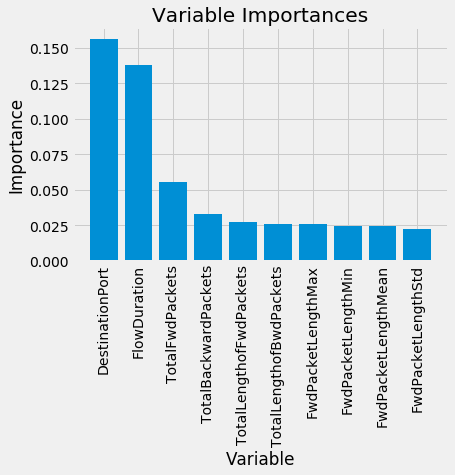

In [12]:
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(feature_importances[:10])))

# Make a bar chart
plt.bar(x_values, feature_importances['importance'][:10], orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, variable_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

plt.savefig('C:/MSc_Felippe/CSC7333_Project/results/RF_Importance_Analysis/Variable_Importances.png', bbox_inches="tight", dpi = 300)